Splitting the training and testing dataset

In [8]:
import os
import shutil
import random

def split_dataset(base_dir, train_ratio=0.7, random_seed=2024):
    images_dir = os.path.join(base_dir, 'images')
    labels_dir = os.path.join(base_dir, 'labels')
    dem_derives_dir = os.path.join(base_dir, 'DEM_derives')  # DEM_derives 文件夹
    train_images_dir = os.path.join(base_dir, 'train', 'images')
    train_labels_dir = os.path.join(base_dir, 'train', 'labels')
    test_images_dir = os.path.join(base_dir, 'test', 'images')
    test_labels_dir = os.path.join(base_dir, 'test', 'labels')
    train_dem_dir = os.path.join(base_dir, 'train', 'DEM_derives') 
    test_dem_dir = os.path.join(base_dir, 'test', 'DEM_derives')      

    os.makedirs(train_images_dir, exist_ok=True)
    os.makedirs(train_labels_dir, exist_ok=True)
    os.makedirs(test_images_dir, exist_ok=True)
    os.makedirs(test_labels_dir, exist_ok=True)
    os.makedirs(train_dem_dir, exist_ok=True)  
    os.makedirs(test_dem_dir, exist_ok=True)   

    image_files = sorted(os.listdir(images_dir))
    

    random.seed(random_seed)

 
    random.shuffle(image_files)


    train_size = int(len(image_files) * train_ratio)

    train_files = image_files[:train_size]
    test_files = image_files[train_size:]


    for file in train_files:

        shutil.copy(os.path.join(images_dir, file), os.path.join(train_images_dir, file))
        label_file = os.path.splitext(file)[0] + '.png' 
        shutil.copy(os.path.join(labels_dir, label_file), os.path.join(train_labels_dir, label_file))

        # 复制 DEM_derives 文件
        for dem_folder in os.listdir(dem_derives_dir):
            dem_folder_path = os.path.join(dem_derives_dir, dem_folder)
            if os.path.isdir(dem_folder_path):  
                dem_file = os.path.splitext(file)[0] + '.tif'  
                if dem_file in os.listdir(dem_folder_path):
                    # 创建目标文件夹
                    target_dem_folder = os.path.join(train_dem_dir, dem_folder)
                    os.makedirs(target_dem_folder, exist_ok=True)  
                    shutil.copy(os.path.join(dem_folder_path, dem_file), os.path.join(target_dem_folder, dem_file))

    for file in test_files:
        shutil.copy(os.path.join(images_dir, file), os.path.join(test_images_dir, file))
        label_file = os.path.splitext(file)[0] + '.png' 
        shutil.copy(os.path.join(labels_dir, label_file), os.path.join(test_labels_dir, label_file))

        for dem_folder in os.listdir(dem_derives_dir):
            dem_folder_path = os.path.join(dem_derives_dir, dem_folder)
            if os.path.isdir(dem_folder_path):  
                dem_file = os.path.splitext(file)[0] + '.tif' 
                if dem_file in os.listdir(dem_folder_path):
                    target_dem_folder = os.path.join(test_dem_dir, dem_folder)
                    os.makedirs(target_dem_folder, exist_ok=True)  
                    shutil.copy(os.path.join(dem_folder_path, dem_file), os.path.join(target_dem_folder, dem_file))

    print(f"Training files: {len(train_files)} | Testing files: {len(test_files)}")

SAT="RLZX-LDD/SAT-LDD"
UAV="RLZX-LDD/UAV-LDD"
split_dataset(SAT)
split_dataset(UAV)

Training files: 1993 | Testing files: 855
Training files: 453 | Testing files: 195


Loading the dataset with training/testing/all mode

In [9]:
from dataloader import *
## Note: Please use absolute path in the .ipynb scripts, but you can use relative path in the .py scripts. This is due to the feature of our dataloader.py.
Dataset_UAV_train=CustomDataset(root_dir=UAV,test=False,use_dem=True,dem_derives=False,target_value=0,source=None)
Dataset_UAV_test=CustomDataset(root_dir=UAV,test=True,use_dem=True,dem_derives=False,target_value=0,source=None)
Dataset_SAT_train=CustomDataset(root_dir=SAT,test=False,use_dem=True,dem_derives=False,target_value=0,source='gaofen')
Dataset_SAT_test=CustomDataset(root_dir=SAT,test=True,use_dem=True,dem_derives=False,target_value=0,source='gaofen')
RGBD_UAV_train=Dataset_UAV_train
RGBD_UAV_test=Dataset_UAV_test
RGBD_SAT_train=Fliter_Dataset(Dataset_SAT_train,3)  ## deleting the NIR band
RGBD_SAT_test=Fliter_Dataset(Dataset_SAT_test,3)   ## deleting the NIR band
print(f"the volume of RGBD_UAV train: {len(RGBD_UAV_train)}")
print(f"the volume of RGBD_UAV test: {len(RGBD_UAV_test)}")
print(f"the volume of RGBD_SAT train: {len(RGBD_SAT_train)}")
print(f"the volume of RGBD_SAT test: {len(RGBD_SAT_test)}")


the volume of RGBD_UAV train: 453
the volume of RGBD_UAV test: 195
the volume of RGBD_SAT train: 1993
the volume of RGBD_SAT test: 855


Visualizing the datasets

Image path: RLZX-LDD/SAT-LDD\train\images\SAT_000293.tif, Label path: RLZX-LDD/SAT-LDD\train\labels\SAT_000293.png


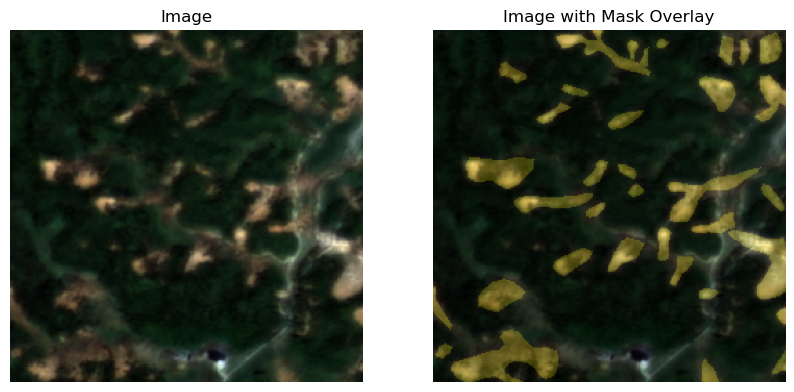

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def visualize_dataset_sample(dataset, idx, alpha=0.5):
    """
    Visualize the image and label from a dataset at index idx with the label mask overlaid on the image.
    
    Args:
        dataset: A dataset where each item is a tuple (img, label).
        idx: The index of the dataset sample to visualize.
        alpha: Transparency level for the mask overlay (0 is fully transparent, 1 is fully opaque).
    """
    img, label, img_path, label_path = dataset[idx]
    print(f"Image path: {img_path}, Label path: {label_path}")
    
    if isinstance(img, torch.Tensor):
        img = img.permute(1, 2, 0).numpy()  
    if isinstance(label, torch.Tensor):
        label = label.numpy()
    
    img = img[:, :, :3]
    img = np.clip(img, 0, 1)
    target_mask = label[1]
    mask_overlay = np.zeros_like(img)  
    mask_overlay[target_mask == 1] = [1, 1, 0]  
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(img)
    plt.imshow(mask_overlay, alpha=alpha) 
    plt.title('Image with Mask Overlay')
    plt.axis('off')
    
    plt.show()

# Usage example:
visualize_dataset_sample(RGBD_SAT_train,222,alpha=0.2)